In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold # for splitting the dataset
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('marketing_campaign.csv', delimiter = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
data.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

## Preprocessors

In [5]:
# function to replace missing value by mode of col    
def replace_nan_mean(data = '', cols = []):
    '''Replaces missing with mode'''
    for col in cols:
        data[col] = data[col].fillna(data[col].mean())
        
# one hot encoding of categorical features
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix = column)
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(column, axis = 1)
    return df

# checking number of unique variables in each columns
def no_unique(df):
    for cols in df.columns:
        print(cols + " " + str(df[cols].nunique()))

In [6]:
no_unique(data)

ID 2240
Year_Birth 59
Education 5
Marital_Status 8
Income 1974
Kidhome 3
Teenhome 3
Dt_Customer 663
Recency 100
MntWines 776
MntFruits 158
MntMeatProducts 558
MntFishProducts 182
MntSweetProducts 177
MntGoldProds 213
NumDealsPurchases 15
NumWebPurchases 15
NumCatalogPurchases 14
NumStorePurchases 14
NumWebVisitsMonth 16
AcceptedCmp3 2
AcceptedCmp4 2
AcceptedCmp5 2
AcceptedCmp1 2
AcceptedCmp2 2
Complain 2
Z_CostContact 1
Z_Revenue 1
Response 2


In [7]:
data = data.drop(['Z_CostContact','Z_Revenue'], axis = 1)

## Preprocessing and Feature Engineering

In [8]:
seed = 1

In [9]:
# preprocessing
def preprocessed_data(df):
    df = df.copy()
    
    # drop id column
    df = df.drop(['ID'], axis = 1)
    
    # fill missing values with mean
    replace_nan_mean(df, ['Income'])
    
    # Date encoding
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
    df['Year_Customer'] = df['Dt_Customer'].apply(lambda x: x.year)
    df['Month_Customer'] = df['Dt_Customer'].apply(lambda x: x.month)
    df['Day_Customer'] = df['Dt_Customer'].apply(lambda x: x.day)
    df = df.drop('Dt_Customer', axis = 1)
        
    # one hot encoding
    for col in ['Education','Marital_Status']:
        df = onehot_encode(df, column = col)
    
    return df

In [10]:
X = preprocessed_data(data)

In [11]:
X

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Year_Customer,Month_Customer,Day_Customer,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,2012,9,4,0,0,1,0,0,0,0,0,0,1,0,0,0
1,1954,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,2014,3,8,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1965,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,2013,8,21,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1984,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,2014,2,10,0,0,1,0,0,0,0,0,0,0,1,0,0
4,1981,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,2014,1,19,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,2013,6,13,0,0,1,0,0,0,0,0,1,0,0,0,0
2236,1946,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,2014,6,10,0,0,0,0,1,0,0,0,0,0,1,0,0
2237,1981,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,2014,1,25,0,0,1,0,0,0,0,1,0,0,0,0,0
2238,1956,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,2014,1,24,0,0,0,1,0,0,0,0,0,0,1,0,0


In [12]:
no_unique(X)

Year_Birth 59
Income 1975
Kidhome 3
Teenhome 3
Recency 100
MntWines 776
MntFruits 158
MntMeatProducts 558
MntFishProducts 182
MntSweetProducts 177
MntGoldProds 213
NumDealsPurchases 15
NumWebPurchases 15
NumCatalogPurchases 14
NumStorePurchases 14
NumWebVisitsMonth 16
AcceptedCmp3 2
AcceptedCmp4 2
AcceptedCmp5 2
AcceptedCmp1 2
AcceptedCmp2 2
Complain 2
Response 2
Year_Customer 3
Month_Customer 12
Day_Customer 31
Education_2n Cycle 2
Education_Basic 2
Education_Graduation 2
Education_Master 2
Education_PhD 2
Marital_Status_Absurd 2
Marital_Status_Alone 2
Marital_Status_Divorced 2
Marital_Status_Married 2
Marital_Status_Single 2
Marital_Status_Together 2
Marital_Status_Widow 2
Marital_Status_YOLO 2


In [13]:
# splitting data into X and y
y = X['Response']
X = X.drop(['Response'], axis = 1)

In [14]:
# splitting data into X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# sampling data
print('Before sampling')
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
print('\n')

X_train_sam, y_train_sam = SMOTE().fit_resample(X_train, y_train)

print('After sampling')
counter = Counter(y_train_sam)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# scaling X set
sc = StandardScaler()
sc.fit(X_train_sam)
X_train_sam = pd.DataFrame(sc.transform(X_train_sam), index= X_train_sam.index, columns = X_train_sam.columns)
X_test = pd.DataFrame(sc.transform(X_test), index= X_test.index, columns = X_test.columns)

Before sampling
Class=1, n=334 (14.911%)
Class=0, n=1906 (85.089%)


After sampling
Class=0, n=1342 (59.911%)
Class=1, n=1342 (59.911%)


In [26]:
lr = LogisticRegression()

# training the model
thresh = 0.319
lr.fit(X_train_sam, y_train_sam)
y_pred = lr.predict(X_test)
print(f1_score(y_test, y_pred))
print(f1_score(y_test, np.where(lr.predict_proba(X_test)[:,1] > thresh, 1, 0)))

0.5643564356435643
0.5982905982905983


In [27]:
rf = RandomForestClassifier(random_state=seed, criterion='entropy', max_features='log2', max_depth=30, class_weight='balanced_subsample')
# training the model
thresh = 0.4
rf.fit(X_train_sam, y_train_sam)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred))
print(f1_score(y_test, np.where(rf.predict_proba(X_test)[:,1] > thresh, 1, 0)))

0.49746192893401014
0.588235294117647


In [36]:
xgb = XGBClassifier()

# training the model
thresh = 0.108
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f1_score(y_test, y_pred))
print(f1_score(y_test, np.where(xgb.predict_proba(X_test)[:,1] > thresh, 1, 0)))

[15:06:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5800000000000001
0.5984251968503937


In [37]:
lgb = LGBMClassifier()

# training the model
thresh = 0.14
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
print(f1_score(y_test, y_pred))
print(f1_score(y_test, np.where(lgb.predict_proba(X_test)[:,1] > thresh, 1, 0)))

0.5435897435897437
0.6007905138339921


In [38]:
cat = CatBoostClassifier(verbose = 0)

# training the model
thresh = 0.194
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
print(f1_score(y_test, y_pred))
print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))

0.5520833333333334
0.5818181818181818


In [39]:
ada = AdaBoostClassifier()

# training the model
thresh = 0.4993
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(f1_score(y_test, y_pred))
print(f1_score(y_test, np.where(ada.predict_proba(X_test)[:,1] > thresh, 1, 0)))

0.5495495495495495
0.5502183406113538


In [40]:
gb = GradientBoostingClassifier(verbose = 0)

# training the model
thresh = 0.411
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(f1_score(y_test, y_pred))
print(f1_score(y_test, np.where(gb.predict_proba(X_test)[:,1] > thresh, 1, 0)))

0.5603864734299517
0.5775862068965516


## Training with keras

In [41]:
X_train.shape

(2684, 38)

In [42]:
y_train

0       0
1       0
2       0
3       1
4       0
       ..
2679    1
2680    1
2681    1
2682    1
2683    1
Name: Response, Length: 2684, dtype: int64

#### training

In [14]:
inputs = tf.keras.Input(shape = (X_train.shape[1],))
x = tf.keras.layers.Dense(128, activation = 'relu')(inputs)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(name = 'auc')
    ]
)

history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
40/40 [==============================] - 1s 12ms/step - loss: 0.4050 - accuracy: 0.8644 - auc: 0.6481 - val_loss: 0.3538 - val_accuracy: 0.8726 - val_auc: 0.8031
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.8955 - auc: 0.8669 - val_loss: 0.2961 - val_accuracy: 0.8917 - val_auc: 0.8762
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2460 - accuracy: 0.9035 - auc: 0.9043 - val_loss: 0.2751 - val_accuracy: 0.9076 - val_auc: 0.8996
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2202 - accuracy: 0.9123 - auc: 0.9282 - val_loss: 0.2701 - val_accuracy: 0.9108 - val_auc: 0.9098
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2023 - accuracy: 0.9187 - auc: 0.9400 - val_loss: 0.2725 - val_accuracy: 0.9172 - val_auc: 0.9112
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1877 - accuracy: 0.9242 - auc: 0.9514 - val_loss: 0.2707 - 

# Results

In [15]:
results = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss: {:.5f}'.format(results[0]))
print('Test Accuracy: {:.2f}%'.format(results[1] * 100))
print('Test AUC: {:.5f}'.format(results[2]))

Test Loss: 0.27514
Test Accuracy: 88.69%
Test AUC: 0.89859


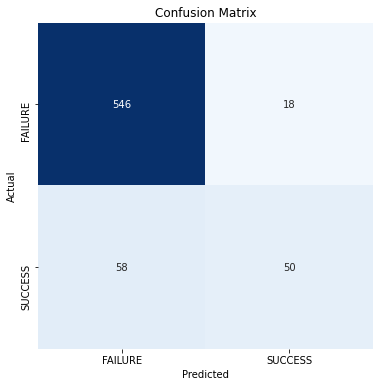

Classification Report:
----------------------
               precision    recall  f1-score   support

     FAILURE       0.90      0.97      0.93       564
     SUCCESS       0.74      0.46      0.57       108

    accuracy                           0.89       672
   macro avg       0.82      0.72      0.75       672
weighted avg       0.88      0.89      0.88       672



In [16]:
y_pred = np.array(model.predict(X_test) >= 0.5, dtype = np.int)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names = ['FAILURE', 'SUCCESS'])

plt.figure(figsize= (6,6))
sns.heatmap(cm, annot = True, fmt = 'g', vmin = 0, cmap = 'Blues', cbar = False)
plt.xticks(ticks = np.arange(2) + 0.5, labels = ['FAILURE', 'SUCCESS'])
plt.yticks(ticks = np.arange(2) + 0.5, labels = ['FAILURE', 'SUCCESS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:\n----------------------\n', clr)